#  Dataset

In [ ]:
import pandas as pd
import os
import shutil
import random
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

## Data Downloading

Use the downloading from Kaggle CLI.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [ ]:
!mv /kaggle/input/brain-tumor-mri-dataset ./

Streaming output truncated to the last 5000 lines.
mv: cannot remove '/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_1157.jpg': Read-only file system
mv: cannot remove '/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_0125.jpg': Read-only file system
mv: cannot remove '/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_0699.jpg': Read-only file system
mv: cannot remove '/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_1273.jpg': Read-only file system
mv: cannot remove '/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_0374.jpg': Read-only file system
mv: cannot remove '/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_1370.jpg': Read-only file system
mv: cannot remove '/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_1171.jpg': Read-only file system
mv: cannot remove '/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_1484.jpg': Read-only file system
mv: cannot remove '/kaggle/input/brain-tumor-

In [ ]:
# Function to load and preprocess each image
def process_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    return image, label

## Train, Test, Validation

Create train, test, validation.

In [ ]:
base_dir = 'brain-tumor-mri-dataset'
training_dir = os.path.join(base_dir, 'Training')
validation_dir = os.path.join(base_dir, 'Validation')
testing_dir = os.path.join(base_dir, 'Testing')

In [ ]:
if not os.path.exists(validation_dir):
    os.makedirs(validation_dir)
    for class_name in os.listdir(training_dir):
        class_val_dir = os.path.join(validation_dir, class_name)
        if not os.path.exists(class_val_dir):
            os.makedirs(class_val_dir)

In [ ]:
random.seed(42)  # For reproducibility
val_split = 0.2

for class_name in os.listdir(training_dir):
    class_train_dir = os.path.join(training_dir, class_name)
    class_val_dir = os.path.join(validation_dir, class_name)

    if os.path.isdir(class_train_dir):
        # List all files in the class directory
        files = [f for f in os.listdir(class_train_dir) if os.path.isfile(os.path.join(class_train_dir, f))]
        random.shuffle(files)  # Shuffle files randomly

        # Calculate number of files for validation
        val_size = int(len(files) * val_split)

        # Split files
        val_files = files[:val_size]
        train_files = files[val_size:]

        # Move validation files to Validation directory
        for file in val_files:
            src = os.path.join(class_train_dir, file)
            dst = os.path.join(class_val_dir, file)
            shutil.move(src, dst)

Create tf dataset.

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory('brain-tumor-mri-dataset/Training',
                                                                 label_mode="categorical",
                                                                 batch_size=32,
                                                                 image_size=(224, 224))

val_data = tf.keras.preprocessing.image_dataset_from_directory('brain-tumor-mri-dataset/Validation',
                                                                 label_mode="categorical",
                                                                 batch_size=32,
                                                                 image_size=(224, 224))

test_data = tf.keras.preprocessing.image_dataset_from_directory('brain-tumor-mri-dataset/Testing',
                                                                 label_mode="categorical",
                                                                 image_size=(224, 224),
                                                                 shuffle=False)

Found 4571 files belonging to 4 classes.
Found 1141 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [ ]:
train_dataset_augmented = train_data.map(process_image)

## Visualization

In [ ]:
def count_files_in_directory(directory):
    label_counts = {}
    # Iterate over subdirectories (class1, class2, class3, class4)
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            # Count image files in the class subdirectory
            files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
            label_counts[class_name] = len(files)
    return label_counts

In [ ]:
train_label_counts = count_files_in_directory(training_dir)
val_label_counts = count_files_in_directory(validation_dir)
test_label_counts = count_files_in_directory(testing_dir)

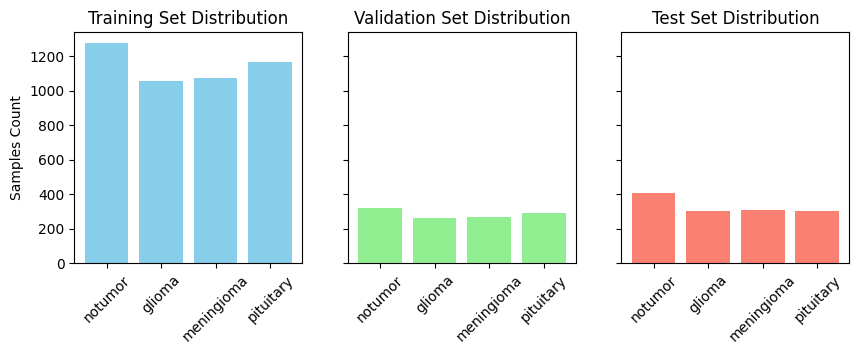

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

# Training set
ax1.bar(train_label_counts.keys(), train_label_counts.values(), color='skyblue')
ax1.set_title('Training Set Distribution')
ax1.set_ylabel('Samples Count')
ax1.tick_params(axis='x', rotation=45)

# Validation set
ax2.bar(val_label_counts.keys(), val_label_counts.values(), color='lightgreen')
ax2.set_title('Validation Set Distribution')
ax2.tick_params(axis='x', rotation=45)

# Test set
ax3.bar(test_label_counts.keys(), test_label_counts.values(), color='salmon')
ax3.set_title('Test Set Distribution')
ax3.tick_params(axis='x', rotation=45)

# Train Feature Extraction Model

Train model for feature extraction.

In [ ]:
!pip install keras

In [ ]:
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Reshape, BatchNormalization, Flatten, Dense
from keras.applications.vgg19 import VGG19
from keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from math import floor

## Hyperparameters

In [ ]:
EPOCHS = 1
INIT_LR = 1e-3
decay_rate = 0.95
decay_step = 1
IMAGE_SIZE = [224, 224]

## Base Model

In [ ]:
def Combined_model():
    # Input layer
    input_layer = Input(shape=(224, 224, 3))

    # Base VGG19 model as a feature extractor
    baseModel = VGG19(weights='imagenet', include_top=False, input_tensor=input_layer)

    # Freeze the layers of the VGG19 model
    for layer in baseModel.layers:
        layer.trainable = False

    x = baseModel.output

    # LSTM layer
    x = Reshape((49, 512))(x)
    x = LSTM(512, activation="relu", return_sequences=True, trainable=False)(x)
    x = BatchNormalization()(x)

    # Flatten output from LSTM
    x = Flatten()(x)

    # Output layer
    output = Dense(4, activation='softmax')(x)

    # Define the model
    model = Model(inputs=input_layer, outputs=output)

    opt = Adam(learning_rate=INIT_LR)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

    return model

In [ ]:
model = Combined_model()
model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 49, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 49, 512)        │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 49, 512)        │         2,04

 Total params: 22,225,988 (84.79 MB)

 Trainable params: 101,380 (396.02 KB)

 Non-trainable params: 22,124,608 (84.40 MB)

## Training Arguments

In [ ]:
save_model_path = '/content/drive/MyDrive/ml-hcmut/model/fe_model.weights.h5'

checkpoint = ModelCheckpoint(filepath=save_model_path,
                             monitor='val_accuracy',
                             mode='max',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True)
earlystop = EarlyStopping(monitor='accuracy',
                          min_delta=0,
                          patience=15,
                          verbose=1,
                          mode='max')
lr_scheduler = LearningRateScheduler(lambda epoch: INIT_LR * pow(decay_rate, floor(epoch / decay_step)))

## Training

In [ ]:
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
history = model.fit(train_dataset_augmented,
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_dataset_augmented),
                    validation_data=val_data,
                    callbacks=[checkpoint, earlystop, lr_scheduler])

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7436 - loss: 0.9830
Epoch 1: val_accuracy improved from -inf to 0.85977, saving model to /content/drive/MyDrive/ml-hcmut/model/svm_fe_model.weights.h5
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 420ms/step - accuracy: 0.7441 - loss: 0.9817 - val_accuracy: 0.8598 - val_loss: 0.6825 - learning_rate: 0.0010


# Extracting Features

In [ ]:
def extract_features(data_generator, model):
    features = []
    labels = []
    for images, batch_labels in data_generator:
        batch_features = model.predict(images)
        features.append(batch_features)
        labels.append(batch_labels.numpy())  # Convert labels to numpy arrays

    # Concatenate all the features and labels
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    return features, labels

In [ ]:
train_features, train_labels = extract_features(train_data, model)
test_features, test_labels = extract_features(test_data, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

# Training SVM

## SKLearn Library

In [ ]:
scaler = StandardScaler()
num_samples, num_features = train_features.shape
pca_components = min(num_samples, num_features, 64)  # Adjust the number of PCA components as needed
pca = PCA(n_components=pca_components)
svm_model = SVC(kernel="poly", degree=2, C=1.0, probability=True)

In [ ]:
train_features_scaled = scaler.fit_transform(train_features)
train_features_pca = pca.fit_transform(train_features_scaled)

In [ ]:
svm_model.fit(train_features_pca, train_labels)

SVC(degree=2, kernel='poly', probability=True)

### Report

In [ ]:
test_features_scaled = scaler.transform(test_features)
test_features_pca = pca.transform(test_features_scaled)
accuracy = svm_model.score(test_features_pca, test_labels)
print(f'SVM Accuracy: {accuracy}')

SVM Accuracy: 0.8184591914569032


In [ ]:
from sklearn.metrics import classification_report

test_predictions = svm_model.predict(test_features_pca)

report = classification_report(test_labels, test_predictions, target_names=test_data.class_names)

print(report)

              precision    recall  f1-score   support

      glioma       0.81      0.68      0.74       300
  meningioma       0.63      0.73      0.68       306
     notumor       0.95      0.91      0.93       405
   pituitary       0.88      0.93      0.90       300

    accuracy                           0.82      1311
   macro avg       0.82      0.81      0.81      1311
weighted avg       0.83      0.82      0.82      1311



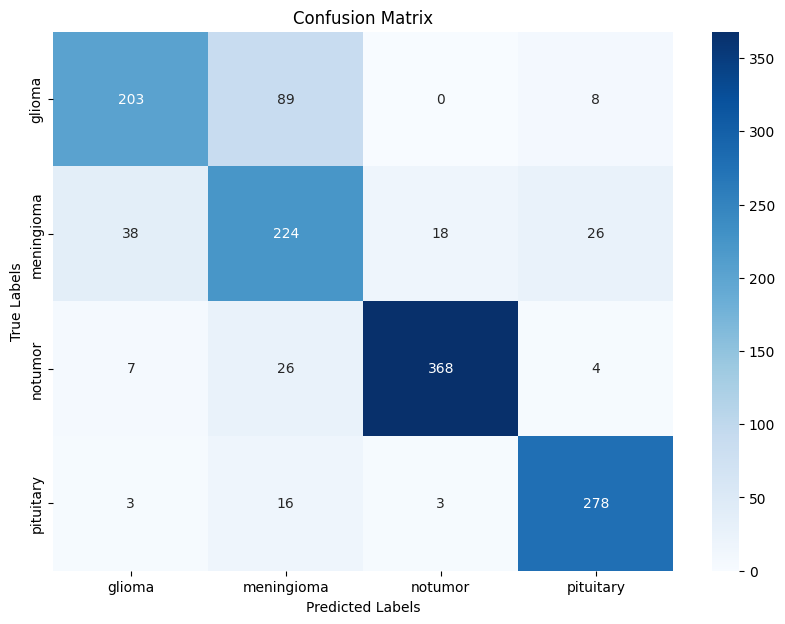

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict the labels of the test set using the trained SVM
test_predictions = svm_model.predict(test_features_pca)

# Generate the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_names, yticklabels=test_data.class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Implemented Model

In [ ]:
import numpy as np
from cvxopt import matrix, solvers

class SVMPolyDegree2:
    def __init__(self, C=1.0):
        self.C = C

    def polynomial_kernel(self, x, y):
        return (np.dot(x, y) + 1) ** 2

    def fit(self, X, y):
        n_samples = X.shape[0]
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.polynomial_kernel(X[i], X[j])

        P = matrix(np.outer(y, y) * K)
        q = matrix(-np.ones(n_samples))
        G = matrix(np.vstack([-np.eye(n_samples), np.eye(n_samples)]))
        h = matrix(np.hstack([np.zeros(n_samples), self.C * np.ones(n_samples)]))
        A = matrix(y.astype(np.double), (1, n_samples))
        b = matrix(0.0)

        solvers.options['show_progress'] = False
        solution = solvers.qp(P, q, G, h, A, b)

        alphas = np.ravel(solution['x'])
        sv = alphas > 1e-5
        self.alpha = alphas[sv]
        self.support_vectors = X[sv]
        self.support_labels = y[sv]

        self.bias = np.mean([
            y_k - np.sum(self.alpha * self.support_labels *
                         [self.polynomial_kernel(x_k, x_sv) for x_sv in self.support_vectors])
            for x_k, y_k in zip(self.support_vectors, self.support_labels)
        ])

    def project(self, X):
        return np.array([
            np.sum(self.alpha * self.support_labels *
                   [self.polynomial_kernel(x, sv) for sv in self.support_vectors])
            + self.bias for x in X
        ])

    def predict(self, X):
        return np.sign(self.project(X))

In [ ]:
class MultiClassSVM_OvR:
    def __init__(self, C=1.0):
        self.C = C
        self.models = {}
        self.classes = []

    def fit(self, X, y):
        self.classes = np.unique(y)
        for cls in self.classes:
            binary_y = np.where(y == cls, 1, -1)
            clf = SVMPolyDegree2(C=self.C)
            clf.fit(X, binary_y)
            self.models[cls] = clf

    def predict(self, X):
        scores = np.column_stack([
            model.project(X) for model in self.models.values()
        ])
        best_class_indices = np.argmax(scores, axis=1)
        return np.array(self.classes)[best_class_indices]

In [ ]:
model = MultiClassSVM_OvR(C=1.0)
model.fit(train_features_pca, train_labels)

### Report

In [ ]:
from sklearn.metrics import classification_report

test_predictions = model.predict(test_features_pca)

report = classification_report(test_labels, test_predictions, target_names=test_data.class_names)

print(report)

              precision    recall  f1-score   support

      glioma       0.84      0.71      0.77       300
  meningioma       0.65      0.71      0.68       306
     notumor       0.92      0.92      0.92       405
   pituitary       0.88      0.93      0.90       300

    accuracy                           0.82      1311
   macro avg       0.82      0.82      0.82      1311
weighted avg       0.83      0.82      0.82      1311



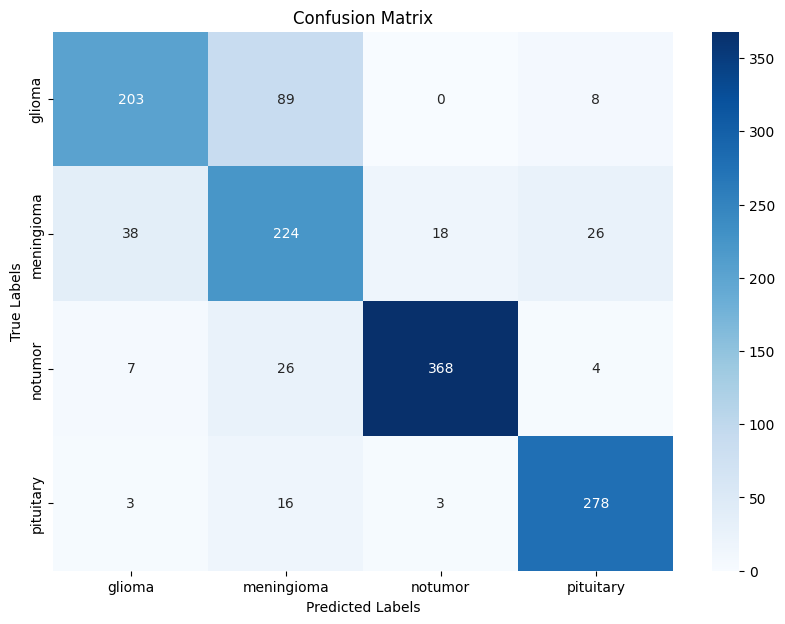

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict the labels of the test set using the trained SVM
test_predictions = model.predict(test_features_pca)

# Generate the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_names, yticklabels=test_data.class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Training Analysis

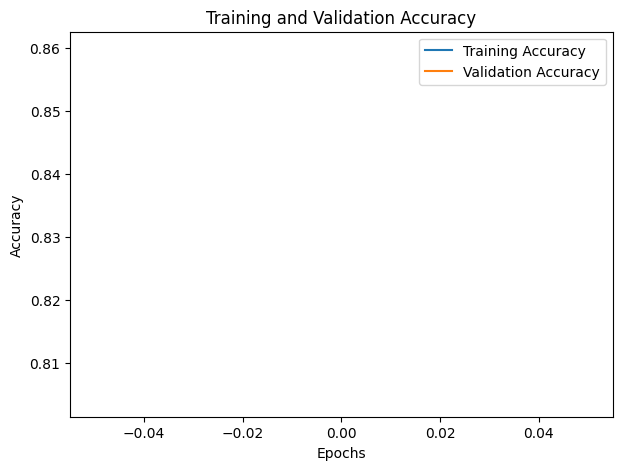

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

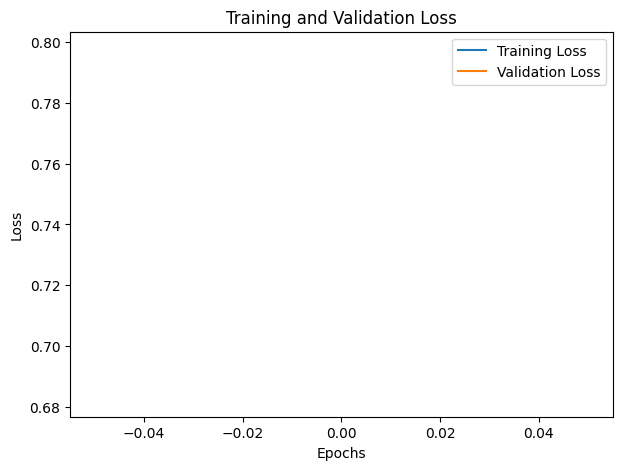

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()